In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import re

from tqdm import tqdm
import time

import pydicom as dicom
import nibabel as nib
import SimpleITK as sitk
import monai

import torch
import torch.nn as nn
import torch.optim as optim

from monai.networks.nets import EfficientNetBN
from monai.networks.nets import ResNet
#from efficientnet_pytorch import EfficientNet
import timm

import wandb


In [2]:
SEED = 344
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # Fix the network according to random seed
    print('Finish seeding with seed {}'.format(seed))
    
seed_everything(SEED)
print('Training on device {}'.format(device))

Finish seeding with seed 344
Training on device cuda


In [3]:
import sklearn.metrics

def transform_6class(label_in):
    kidney_label = label_in[0:2]
    liver_label = label_in[2:4]
    spleen_label = label_in[4:6]
    
    label_out = np.zeros(13)
    
    label_out[0:2] = kidney_label
    label_out[2:4] = kidney_label
    label_out[4] = (1 - kidney_label[0]) * (1 - kidney_label[1])
    label_out[5:7] = kidney_label
    label_out[7] = (1 - liver_label[0]) * (1 - liver_label[1])
    label_out[8:10] = liver_label
    label_out[10] = (1 - spleen_label[0]) * (1 - spleen_label[1])
    label_out[11:13] = spleen_label
    
    label_out_reweight = np.copy(label_out)
    
    label_out_reweight[4] = label_out[4] / np.sum(label_out[4:7])
    label_out_reweight[5] = label_out[5] / np.sum(label_out[4:7])
    label_out_reweight[6] = label_out[6] / np.sum(label_out[4:7])
    
    label_out_reweight[7] = label_out[7] / np.sum(label_out[7:10])
    label_out_reweight[8] = label_out[8] / np.sum(label_out[7:10])
    label_out_reweight[9] = label_out[9] / np.sum(label_out[7:10])
    
    label_out_reweight[10] = label_out[10] / np.sum(label_out[10:13])
    label_out_reweight[11] = label_out[11] / np.sum(label_out[10:13])
    label_out_reweight[12] = label_out[12] / np.sum(label_out[10:13])
    
    return label_out_reweight.tolist()

def transform_13class(label_in):
    label_out = np.copy(label_in)
    label_out_reweight = np.copy(label_in)
    
    label_out_reweight[0] = label_out[4] / np.sum(label_out[4:7])
    label_out_reweight[1] = label_out[5] / np.sum(label_out[4:7])
    
    label_out_reweight[2] = label_out[4] / np.sum(label_out[4:7])
    label_out_reweight[3] = label_out[5] / np.sum(label_out[4:7])
    
    label_out_reweight[4] = label_out[4] / np.sum(label_out[4:7])
    label_out_reweight[5] = label_out[5] / np.sum(label_out[4:7])
    label_out_reweight[6] = label_out[6] / np.sum(label_out[4:7])
    
    label_out_reweight[7] = label_out[7] / np.sum(label_out[7:10])
    label_out_reweight[8] = label_out[8] / np.sum(label_out[7:10])
    label_out_reweight[9] = label_out[9] / np.sum(label_out[7:10])
    
    label_out_reweight[10] = label_out[10] / np.sum(label_out[10:13])
    label_out_reweight[11] = label_out[11] / np.sum(label_out[10:13])
    label_out_reweight[12] = label_out[12] / np.sum(label_out[10:13])
    
    return label_out_reweight.tolist()

def transform_8class(label_in):
    bowel_label = label_in[0]
    extravasation_label = label_in[1]
    kidney_label = label_in[2:4]
    liver_label = label_in[4:6]
    spleen_label = label_in[6:8]
    
    label_out = np.zeros(13)
    
    label_out[0:2] = [1 - bowel_label, bowel_label]
    label_out[2:4] = [1 - extravasation_label, extravasation_label]
#     label_out[0:2] = [0.89, 0.11]
#     label_out[2:4] = [0.71, 0.29]
    label_out[4] = (1 - kidney_label[0]) * (1 - kidney_label[1])
    label_out[5:7] = kidney_label
    label_out[7] = (1 - liver_label[0]) * (1 - liver_label[1])
    label_out[8:10] = liver_label
    label_out[10] = (1 - spleen_label[0]) * (1 - spleen_label[1])
    label_out[11:13] = spleen_label
    
    label_out_reweight = np.copy(label_out)
    
    label_out_reweight[4] = label_out[4] / np.sum(label_out[4:7])
    label_out_reweight[5] = label_out[5] / np.sum(label_out[4:7])
    label_out_reweight[6] = label_out[6] / np.sum(label_out[4:7])
    
    label_out_reweight[7] = label_out[7] / np.sum(label_out[7:10])
    label_out_reweight[8] = label_out[8] / np.sum(label_out[7:10])
    label_out_reweight[9] = label_out[9] / np.sum(label_out[7:10])
    
    label_out_reweight[10] = label_out[10] / np.sum(label_out[10:13])
    label_out_reweight[11] = label_out[11] / np.sum(label_out[10:13])
    label_out_reweight[12] = label_out[12] / np.sum(label_out[10:13])
    
    return label_out_reweight.tolist()

def loss_metrics(metrics, transform):
    preds = [transform(x) for x in metrics["predict"]]
    targets = [transform(x) for x in metrics["label"]]
    targets_any_injury = metrics["label"][:, -1]
    
    loss_list = []
    
    print("F1 score: ", sklearn.metrics.f1_score(np.around(targets), np.around(preds), average=None, zero_division=0.0))
    auc = sklearn.metrics.roc_auc_score(np.around(targets),preds, average=None)
    print("AUC score: ", auc)
    print("Average AUC: ", np.mean(auc))
        
    
    
    #print(np.array(preds).shape)
    

In [54]:
# True score

def normalize_probabilities_to_one(df: pd.DataFrame, group_columns: list) -> pd.DataFrame:
    # Normalize the sum of each row's probabilities to 100%.
    # 0.75, 0.75 => 0.5, 0.5
    # 0.1, 0.1 => 0.5, 0.5
    row_totals = df[group_columns].sum(axis=1)
    if row_totals.min() == 0:
        raise ParticipantVisibleError('All rows must contain at least one non-zero prediction')
    for col in group_columns:
        df[col] /= row_totals
    return df


def score(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
    '''
    Pseudocode:
    1. For every label group (liver, bowel, etc):
        - Normalize the sum of each row's probabilities to 100%.
        - Calculate the sample weighted log loss.
    2. Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    3. Calculate the sample weighted log loss for the new label group
    4. Return the average of all of the label group log losses as the final score.
    '''

    # Run basic QC checks on the inputs
    if not pd.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('All submission values must be numeric')

    if not np.isfinite(submission.values).all():
        raise ParticipantVisibleError('All submission values must be finite')

    if solution.min().min() < 0:
        raise ParticipantVisibleError('All labels must be at least zero')
    if submission.min().min() < 0:
        raise ParticipantVisibleError('All predictions must be at least zero')

    # Calculate the label group log losses
    binary_targets = []
    triple_level_targets = ['kidney', 'liver', 'spleen']
    all_target_categories = binary_targets + triple_level_targets

    label_group_losses = []
    for category in all_target_categories:
        if category in binary_targets:
            col_group = [f'{category}_healthy', f'{category}_injury']
        else:
            col_group = [f'{category}_healthy', f'{category}_low', f'{category}_high']

        solution = normalize_probabilities_to_one(solution, col_group)

        for col in col_group:
            if col not in submission.columns:
                raise ParticipantVisibleError(f'Missing submission column {col}')
        submission = normalize_probabilities_to_one(submission, col_group)
        label_group_losses.append(
            sklearn.metrics.log_loss(
                y_true=solution[col_group].values,
                y_pred=submission[col_group].values,
                sample_weight=solution[f'{category}_weight'].values
            )
        )

    # Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    healthy_cols = [x + '_healthy' for x in all_target_categories]
    any_injury_labels = (1 - solution[healthy_cols]).max(axis=1)
    any_injury_predictions = (1 - submission[healthy_cols]).max(axis=1)
    any_injury_loss = sklearn.metrics.log_loss(
        y_true=any_injury_labels.values,
        y_pred=any_injury_predictions.values,
        sample_weight=solution['any_injury_weight'].values
    )

    label_group_losses.append(any_injury_loss)
    return np.mean(label_group_losses)

def create_training_solution(y_train):
    sol_train = y_train.copy()
    
    # bowel healthy|injury sample weight = 1|2
    sol_train['bowel_weight'] = np.where(sol_train['bowel_injury'] == 1, 2, 1)
    
    # extravasation healthy/injury sample weight = 1|6
    sol_train['extravasation_weight'] = np.where(sol_train['extravasation_injury'] == 1, 6, 1)
    
    # kidney healthy|low|high sample weight = 1|2|4
    sol_train['kidney_weight'] = np.where(sol_train['kidney_low'] == 1, 2, np.where(sol_train['kidney_high'] == 1, 4, 1))
    
    # liver healthy|low|high sample weight = 1|2|4
    sol_train['liver_weight'] = np.where(sol_train['liver_low'] == 1, 2, np.where(sol_train['liver_high'] == 1, 4, 1))
    
    # spleen healthy|low|high sample weight = 1|2|4
    sol_train['spleen_weight'] = np.where(sol_train['spleen_low'] == 1, 2, np.where(sol_train['spleen_high'] == 1, 4, 1))
    
    # any healthy|injury sample weight = 1|6
    sol_train['any_injury_weight'] = np.where(sol_train['any_injury'] == 1, 6, 1)
    return sol_train

In [55]:
fullvol_effnet = pd.read_csv('autodl-tmp/kls_outputs/kls_effnet.csv')
fullvol_effnetx2 = pd.read_csv('autodl-tmp/kls_outputs/kls_effnetx2.csv')
fullvol_convnext = pd.read_csv('autodl-tmp/kls_outputs/kls_convnext.csv')
fullvol_convnextx2 = pd.read_csv('autodl-tmp/kls_outputs/kls_convnextx2.csv')
fullvol_labels = pd.read_csv('autodl-tmp/kls_outputs/kls_labels.csv')

predicts = {}
predicts_transform = {}
labels = fullvol_labels.loc[:, :].values
predicts['effnet'] = fullvol_effnet.loc[:, :].values
predicts['effnetx2'] = fullvol_effnetx2.loc[:, :].values
predicts['convnext'] = fullvol_convnext.loc[:, :].values
predicts['convnextx2'] = fullvol_convnextx2.loc[:, :].values

predicts_transform['effnet'] = np.array([transform_6class(x) for x in predicts['effnet']])
predicts_transform['effnetx2'] = np.array([transform_6class(x) for x in predicts['effnetx2']])
predicts_transform['convnext'] = np.array([transform_6class(x) for x in predicts['convnext']])
predicts_transform['convnextx2'] = np.array([transform_6class(x) for x in predicts['convnextx2']])
labels_transform = np.round(np.array([transform_6class(x) for x in labels]))

In [56]:
label_columns = [
            'bowel_healthy',
            'bowel_injury',
            'extravasation_healthy',
            'extravasation_injury',
            'kidney_healthy',
            'kidney_low',
            'kidney_high',
            'liver_healthy',
            'liver_low',
            'liver_high',
            'spleen_healthy',
            'spleen_low',
            'spleen_high',
            'any_injury']

targets_any_injury = np.zeros(len(fullvol_labels))
for i in range(0, len(fullvol_labels)):
    target = labels_transform[i]
    target_any_injury = max([1 - target[x] for x in [0, 2, 4, 7, 10]])
    targets_any_injury[i] = target_any_injury
targets_any_injury = np.expand_dims(targets_any_injury, -1)
labels_transform_pd = pd.DataFrame(data = np.concatenate([labels_transform, targets_any_injury], axis=-1), columns=label_columns)
labels_transform_pd

,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4392,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4393,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4394,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4395,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [57]:
labels_sol_pd = create_training_solution(labels_transform_pd)
labels_sol_pd

,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,bowel_weight,extravasation_weight,kidney_weight,liver_weight,spleen_weight,any_injury_weight
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,2,1,4,6
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,2,1,4,6
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,1,1,1,1,6
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,1,1,1,1,6
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,1,1,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4392,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,1,1,1,1,6
4393,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,1,1,1,1,6
4394,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,1,1,4,6
4395,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,1,1,4,6


In [59]:
preds_columns = [
            'bowel_healthy',
            'bowel_injury',
            'extravasation_healthy',
            'extravasation_injury',
            'kidney_healthy',
            'kidney_low',
            'kidney_high',
            'liver_healthy',
            'liver_low',
            'liver_high',
            'spleen_healthy',
            'spleen_low',
            'spleen_high',]

predicts_transform_pd = {}
predicts_transform_pd['effnet'] = pd.DataFrame(data = predicts_transform['effnet'], columns=preds_columns)
predicts_transform_pd['effnetx2'] = pd.DataFrame(data = predicts_transform['effnetx2'], columns=preds_columns)
predicts_transform_pd['convnext'] = pd.DataFrame(data = predicts_transform['convnext'], columns=preds_columns)
predicts_transform_pd['convnextx2'] = pd.DataFrame(data = predicts_transform['convnextx2'], columns=preds_columns)

In [60]:
print("EffNet:", score(labels_sol_pd, predicts_transform_pd['effnet']))
print()

print("EffNet x2:", score(labels_sol_pd, predicts_transform_pd['effnetx2']))
print()

print("Convnext:", score(labels_sol_pd, predicts_transform_pd['convnext']))
print()

print("Convnext x2:", score(labels_sol_pd, predicts_transform_pd['convnextx2']))
print()

EffNet: 0.6302433008328321

EffNet x2: 0.6569241064708156

Convnext: 0.6558635333564913

Convnext x2: 0.6310696676015307



In [10]:
# metric = {'predict': np.array(predicts_transform['effnetx2'][0:1178]), 'label': labels_transform[0:1178]}
# print("EffNet x2 fold 1:")
# print("Weighted Loss: ", loss_metrics(metric, transform_13class))
# print()

# metric = {'predict': np.array(predicts_transform['effnetx2'][1178:2356]), 'label': labels_transform[1178:2356]}
# print("EffNet x2 fold 2:")
# print("Weighted Loss: ", loss_metrics(metric, transform_13class))
# print()

# metric = {'predict': np.array(predicts_transform['effnetx2'][2356:3534]), 'label': labels_transform[2356:3534]}
# print("EffNet x2 fold 3:")
# print("Weighted Loss: ", loss_metrics(metric, transform_13class))
# print()

# metric = {'predict': np.array(predicts_transform['effnetx2'][3534:]), 'label': labels_transform[3534:]}
# print("EffNet x2 fold 4:")
# print("Weighted Loss: ", loss_metrics(metric, transform_13class))
# print()

In [11]:
metric = {'predict': np.array(predicts_transform['effnetx2']), 'label': labels_transform}
print("EffNet x2:")
print("Weighted Loss: ", loss_metrics(metric, transform_13class))
print()

metric = {'predict': np.array(predicts_transform['effnet']), 'label': labels_transform}
print("EffNet:")
print("Weighted Loss: ", loss_metrics(metric, transform_13class))
print()

metric = {'predict': np.array(predicts_transform['convnextx2']), 'label': labels_transform}
print("ConvNextx2:")
print("Weighted Loss: ", loss_metrics(metric, transform_13class))
print()

metric = {'predict': np.array(predicts_transform['convnext']), 'label': labels_transform}
print("ConvNext:")
print("Weighted Loss: ", loss_metrics(metric, transform_13class))
print()

predicts_transform_mean = np.average([predicts_transform['effnet'], predicts_transform['effnetx2'], predicts_transform['convnext'], predicts_transform['convnextx2']], 
                                  axis=0, weights=[1, 1, 1, 1])

metric = {'predict': predicts_transform_mean, 'label': labels_transform}
print("Average:")
print("Weighted Loss: ", loss_metrics(metric, transform_13class))
print()

EffNet x2:
F1 score:  [0.86835409 0.15496368 0.86835409 0.15496368 0.86835409 0.15496368
 0.16326531 0.83861835 0.26300294 0.11009174 0.83350151 0.13851351
 0.40920716]
AUC score:  [0.80864127 0.76913659 0.80864127 0.76913659 0.80864127 0.76913659
 0.81977523 0.77114799 0.72910852 0.84781588 0.81180371 0.69386898
 0.88167721]
Average AUC:  0.7914254702095689
Weighted Loss:  0.48299485010617776

EffNet:
F1 score:  [0.88967044 0.10857143 0.88967044 0.10857143 0.88967044 0.10857143
 0.03225806 0.851656   0.25902335 0.         0.85136274 0.09766454
 0.35403727]
AUC score:  [0.76494647 0.71295646 0.76494647 0.71295646 0.76494647 0.71295646
 0.79533116 0.76005453 0.72850852 0.82705331 0.78163965 0.70011374
 0.83178547]
Average AUC:  0.7583227056932503
Weighted Loss:  0.45146483560877343

ConvNextx2:
F1 score:  [0.88789119 0.19534884 0.88789119 0.19534884 0.88789119 0.19534884
 0.22826087 0.83019951 0.29219144 0.02150538 0.85843715 0.17614679
 0.4       ]
AUC score:  [0.84591979 0.79815364 0.

In [157]:
predicts_transform_mean = np.average([predicts_transform['effnet'], predicts_transform['effnetx2'], 
                                      predicts_transform['convnext'], predicts_transform['convnextx2']], 
                                  axis=0, weights=[1, 2, 3, 4])

predicts_transform_mean_pd = pd.DataFrame(data = predicts_transform_mean, columns=preds_columns)

metric = {'predict': predicts_transform_mean, 'label': labels_transform}
print("Average: ", score(labels_sol_pd, predicts_transform_mean_pd))
loss_metrics(metric, transform_13class)
print()

Average:  0.5777586930021101
F1 score:  [0.8932141  0.13148789 0.8932141  0.13148789 0.8932141  0.13148789
 0.13114754 0.85147679 0.31555556 0.02222222 0.87489505 0.11369509
 0.46327684]
AUC score:  [0.85917428 0.81043634 0.85917428 0.81043634 0.85917428 0.81043634
 0.87948118 0.81798003 0.77981862 0.92007479 0.86552158 0.77199525
 0.92731817]
Average AUC:  0.8439247308410638



In [170]:
def post_rescale_3(x, y):
    divider = y[0] + y[1] + y[2]
    a = y[0] / x[0] / divider
    b = y[1] / x[1] / divider
    c = y[2] / x[2] / divider
    
    return a, b, c

def post_rescale_2(x, y):
    divider = y[0] + y[1]
    a = y[0] / x[0] / divider
    b = y[1] / x[1] / divider
    
    return a, b

def test_scale(test_weight, train_weight):
    scale_list = np.zeros(13)
    scale_list[0], scale_list[1] = post_rescale_2(test_weight[0:2], train_weight[0:2])
    scale_list[2], scale_list[3] = post_rescale_2(test_weight[2:4], train_weight[2:4])
    scale_list[4], scale_list[5], scale_list[6] = post_rescale_3(test_weight[4:7], train_weight[4:7])
    scale_list[7], scale_list[8], scale_list[9] = post_rescale_3(test_weight[7:10], train_weight[7:10])
    scale_list[10], scale_list[11], scale_list[12] = post_rescale_3(test_weight[10:13], train_weight[10:13])
    
    return scale_list


def rescale(outputs):
    test_weight = [np.mean(outputs[:, 0]),
                  np.mean(outputs[:, 1]),
                  np.mean(outputs[:, 2]),
                  np.mean(outputs[:, 3]),
                  np.mean(outputs[:, 4]),
                  np.mean(outputs[:, 5]),
                  np.mean(outputs[:, 6]),
                  np.mean(outputs[:, 7]),
                  np.mean(outputs[:, 8]),
                  np.mean(outputs[:, 9]),
                  np.mean(outputs[:, 10]),
                  np.mean(outputs[:, 11]),
                  np.mean(outputs[:, 12])]
    # train_weight = [0.9749560397520781,
    #                 0.09846138671750874,
    #                 0.9319479238239943,
    #                 1.322933049253257,
    #                 0.9376401744615348,
    #                 0.10400623143247538,
    #                 0.10307676421989195,
    #                 0.8936833500938608,
    #                 0.23424012122618368,
    #                 0.09538446838258659,
    #                 0.8832475572583699,
    #                 0.17997600047880524,
    #                 0.1401823119307277]
    w = 0.5
    train_weight = [1 - w * test_weight[1], w * test_weight[1],
                   1 - w * test_weight[3], w * test_weight[3],
                   1 - w * test_weight[5] - w * test_weight[6], w * test_weight[5], w * test_weight[6],
                   1 - w * test_weight[8] - w * test_weight[9], w * test_weight[8], w * test_weight[9],
                   1 - w * test_weight[11] - w * test_weight[12], w * test_weight[11], w * test_weight[12]]
    
    scale_list = test_scale(test_weight, train_weight)
    print(scale_list)
    
    rescale_outputs = np.stack([scale_list[x] * outputs[:, x] for x in range(0, 13)], axis=-1)
    return rescale_outputs
    

In [171]:
predicts_rescale = rescale(predicts_transform_mean)
predicts_rescale = np.array([transform_13class(output) for output in predicts_rescale])

[4.05808455 0.7        4.05808455 0.7        1.14405064 0.7
 0.7        1.16942709 0.7        0.7        1.18229679 0.7
 0.7       ]


In [172]:
[np.mean(predicts_rescale[:, x]) for x in range(0, 13)]

[0.7534544871140494,
 0.15008634039673338,
 0.7534544871140494,
 0.15008634039673338,
 0.7534544871140494,
 0.15008634039673338,
 0.09645917248921729,
 0.724461330012157,
 0.20493915454560688,
 0.07059951544223618,
 0.7111342424225358,
 0.17274931142240896,
 0.11611644615505544]

In [173]:
predicts_rescale_pd = pd.DataFrame(data = predicts_rescale, columns=preds_columns)

metric = {'predict': predicts_rescale, 'label': labels_transform}
print("Average: ", score(labels_sol_pd, predicts_rescale_pd))
loss_metrics(metric, transform_13class)
print()

Average:  0.49895944644969753
F1 score:  [0.93547175 0.09661836 0.93547175 0.09661836 0.93547175 0.09661836
 0.10434783 0.90963934 0.26143791 0.         0.92514497 0.0516129
 0.425     ]
AUC score:  [0.85917428 0.81322109 0.85917428 0.81322109 0.85917428 0.81322109
 0.88389009 0.81798003 0.78335673 0.91952098 0.86552158 0.77827296
 0.92942953]
Average AUC:  0.8457813870888357



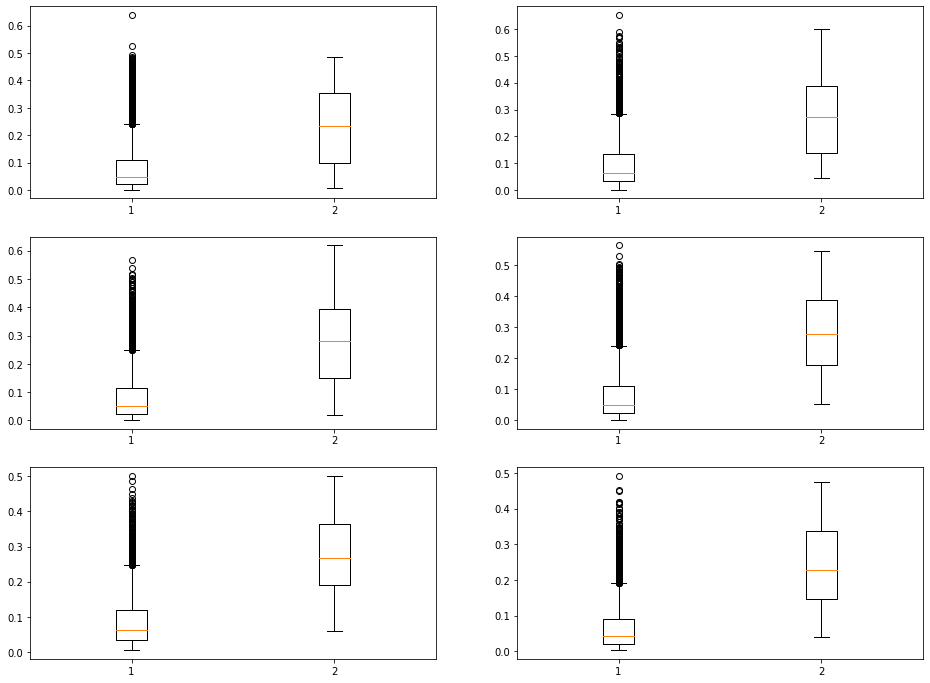

In [175]:
l = -4

# predict = predicts_rescale


plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
predict = predicts_transform['effnet']
plt.boxplot([predict[labels_transform[:, l] == 0, l], predict[labels_transform[:, l] == 1, l]])
plt.subplot(3, 2, 2)
predict = predicts_transform['effnetx2']
plt.boxplot([predict[labels_transform[:, l] == 0, l], predict[labels_transform[:, l] == 1, l]])
plt.subplot(3, 2, 3)
predict = predicts_transform['convnext']
plt.boxplot([predict[labels_transform[:, l] == 0, l], predict[labels_transform[:, l] == 1, l]])
plt.subplot(3, 2, 4)
predict = predicts_transform['convnextx2']
plt.boxplot([predict[labels_transform[:, l] == 0, l], predict[labels_transform[:, l] == 1, l]])
plt.subplot(3, 2, 5)
predict = predicts_transform_mean
plt.boxplot([predict[labels_transform[:, l] == 0, l], predict[labels_transform[:, l] == 1, l]])
plt.subplot(3, 2, 6)
predict = predicts_rescale
plt.boxplot([predict[labels_transform[:, l] == 0, l], predict[labels_transform[:, l] == 1, l]])
plt.show()

In [18]:
def post_rescale_3(x, y):
    divider = y[0] + y[1] + y[2]
    a = y[0] / x[0] / divider
    b = y[1] / x[1] / divider
    c = y[2] / x[2] / divider
    
    return a, b, c

def post_rescale_2(x, y):
    divider = y[0] + y[1]
    a = y[0] / x[0] / divider
    b = y[1] / x[1] / divider
    
    return a, b

def test_scale(test_weight, train_weight):
    scale_list = np.zeros(13)
    scale_list[0], test_weight[1] = post_rescale_2(test_weight[0:2], train_weight[0:2])
    scale_list[2], test_weight[3] = post_rescale_2(test_weight[2:4], train_weight[2:4])